In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary


In [3]:
!nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Tue Aug 24 07:16:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
# Hyper Parameters
EPOCH = 5
BATCH_SIZE = 64
LR = 0.01
MOMENTUM = 0.9
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DOWNLOAD = True

In [16]:
# Transform
transform = transforms.Compose(
                [
                 transforms.Resize(size=(224,224)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5,), (0.5,)),                 
                 transforms.RandomHorizontalFlip(),
                ]
                )

# Data
train_dataset = datasets.CIFAR10(root='/dataset', train=True, download=DOWNLOAD, transform=transform)
valid_dataset = datasets.CIFAR10(root='/dataset', train=False, download=DOWNLOAD, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Inception V1
class Inception_Module(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2_1, out_channels2_2, out_channels3_1, out_channels3_2, out_channels4):
        super(Inception_Module, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels1),
            nn.ReLU(inplace=True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels2_1, kernel_size=1, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels2_1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels2_1, out_channels=out_channels2_2, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels2_2),
            nn.ReLU(inplace=True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels3_1, kernel_size=1, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels3_1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels3_1, out_channels=out_channels3_2, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels3_2),
            nn.ReLU(inplace=True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),       
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels4, kernel_size=1, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels4),
            nn.ReLU(inplace=True),
        )
        

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)        
        out3 = self.branch3(x)        
        out4 = self.branch4(x)        

        outputs = torch.cat([out1, out2, out3, out4], dim=1)
        return outputs

In [18]:
class Auxiliary_Classifiers(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Auxiliary_Classifiers, self).__init__()
        self.AvgPool2d = nn.AvgPool2d(kernel_size=5, stride=3)
        self.Conv      = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),    
        )        
        self.FC1       = nn.Linear(in_features=2048, out_features=1024)
        self.FC2       = nn.Linear(in_features=1024, out_features=out_channels)
        self.ReLU      = nn.ReLU(inplace=True)
        self.Dropout   = nn.Dropout(p=0.5)        

    def forward(self, x):
        x = self.AvgPool2d(x)
        x = self.Conv(x)
        x = torch.flatten(x,1)
        x = self.FC1(x)
        x = self.ReLU(x)
        x = self.Dropout(x)
        x = self.FC2(x)        

        return x

In [19]:
# Inception V1
class GoogleNet(nn.Module):
    def __init__(self, num_classes, aux_classfier=False):
        super(GoogleNet, self).__init__()
        self.aux_classfier = aux_classfier
        self.Conv_Stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.Inception1 = Inception_Module(192, 64, 96, 128, 16, 32, 32)
        self.Inception2 = Inception_Module(256, 128, 128, 192, 32, 96, 64)
        self.Inception3 = Inception_Module(480, 192, 96, 208, 16, 48, 64)
        self.Inception4 = Inception_Module(512, 160, 112, 224, 24, 64, 64)
        self.Inception5 = Inception_Module(512, 128, 128, 256, 24, 64, 64)
        self.Inception6 = Inception_Module(512, 112, 144, 288, 32, 64, 64)
        self.Inception7 = Inception_Module(528, 256, 160, 320, 32, 128, 128)
        self.Inception8 = Inception_Module(832, 256, 160, 320 ,32 ,128, 128)        
        self.Inception9 = Inception_Module(832, 384, 192, 384, 48, 128, 128)
                
        self.MaxPool2d  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.AvgPool2d  = nn.AvgPool2d(kernel_size=7, stride=1)
        self.Dropout    = nn.Dropout(p=0.3)
        self.FC         = nn.Linear(in_features=1024, out_features=num_classes)
        self.auxiliary1 = Auxiliary_Classifiers(in_channels=512, out_channels=num_classes)
        self.auxiliary2 = Auxiliary_Classifiers(in_channels=528, out_channels=num_classes)
                        

    def forward(self, x):
        x = self.Conv_Stem(x)
        x = self.Inception1(x)
        x = self.Inception2(x)
        x = self.MaxPool2d(x)
        x = self.Inception3(x)
        if self.aux_classfier is True:
          aux1 = self.auxiliary1(x)
        x = self.Inception4(x)
        x = self.Inception5(x)
        x = self.Inception6(x)
        if self.aux_classfier is True:
          aux2 = self.auxiliary2(x)
        x = self.Inception7(x)
        x = self.MaxPool2d(x)
        x = self.Inception8(x)
        x = self.Inception9(x)
        x = self.AvgPool2d(x)
        x = self.Dropout(x)
        x = torch.flatten(x,1)
        x = self.FC(x)      

        if self.aux_classfier is True:
          return x, aux1, aux2
        else:
          return x

In [20]:
model = GoogleNet(num_classes, aux_classfier=True)
model = model.to(device)
# summary(model, (3,224,224))
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()
# print(model)


In [21]:
def train(epoch):
    print('\nEpoch: %d' % epoch)    
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0            
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        loss = torch.Tensor([0.0]).float().to(device)
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        optimizer.zero_grad()        
        outputs, aux1, aux2 = model(inputs)
                
        loss_output = criterion(outputs, targets)
        loss_aux1 = criterion(aux1, targets) 
        loss_aux2 = criterion(aux2, targets) 
        loss = loss_output + loss_aux1 * 0.3 + loss_aux2 * 0.3
        
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            train_acc_per_epoch = 100 * (correct / float(total))
            train_loss_per_epoch = train_loss / total
            print("Train Epoch: {}/{} [iter： {:03d}/{:03d}], acc： {:.6f}, loss： {:.6f}".format(
               epoch, EPOCH, batch_idx+1, len(train_loader),
               train_acc_per_epoch,
               train_loss_per_epoch))
    return train_acc_per_epoch, train_loss_per_epoch


In [22]:
def test(epoch):        
    model.eval()
    test_loss = 0
    correct = 0
    total = 0    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            loss = torch.Tensor([0.0]).float().to(device)
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs, _ , _ = model(inputs)            
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 100 == 0:     
              test_acc_per_epoch = 100 * (correct / float(total))
              test_loss_per_epoch = test_loss / total
              print("Valid Epoch: {}/{} [iter： {:03d}/{:03d}], acc： {:.6f}, loss： {:.6f}".format(
                epoch, EPOCH, batch_idx+1, len(valid_loader),                
                test_acc_per_epoch,
                test_loss_per_epoch))                
            
    return test_acc_per_epoch, test_loss_per_epoch

In [23]:
def training_loop():
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(1,EPOCH+1):
        # training
        
        train_acc_, train_loss_ = train(epoch)
        total_train_accuracy.append(train_acc_)
        total_train_loss.append(train_loss_)
        
        valid_acc_, valid_loss_ = test(epoch)        
        total_valid_accuracy.append(valid_acc_)
        total_valid_loss.append(valid_loss_)

        print('==========================================================================')
        print("Epoch: {:05d}/{:05d}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch, EPOCH, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    # print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [24]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop()


Epoch: 1
Train Epoch: 1/5 [iter： 001/782], acc： 3.125000, loss： 0.057946
Train Epoch: 1/5 [iter： 101/782], acc： 29.919554, loss： 0.046600
Train Epoch: 1/5 [iter： 201/782], acc： 35.424440, loss： 0.043068
Train Epoch: 1/5 [iter： 301/782], acc： 39.072882, loss： 0.040793
Train Epoch: 1/5 [iter： 401/782], acc： 42.378429, loss： 0.038922
Train Epoch: 1/5 [iter： 501/782], acc： 45.013099, loss： 0.037253
Train Epoch: 1/5 [iter： 601/782], acc： 47.231177, loss： 0.035841
Train Epoch: 1/5 [iter： 701/782], acc： 49.418242, loss： 0.034500
Valid Epoch: 1/5 [iter： 001/157], acc： 56.250000, loss： 0.019247
Valid Epoch: 1/5 [iter： 101/157], acc： 58.864480, loss： 0.019798
Epoch: 00001/00005， Train acc： 49.418242， Train loss： 0.034500， Valid acc： 58.864480， Valid loss： 0.019798

Epoch: 2
Train Epoch: 2/5 [iter： 001/782], acc： 75.000000, loss： 0.023019
Train Epoch: 2/5 [iter： 101/782], acc： 65.068069, loss： 0.023942
Train Epoch: 2/5 [iter： 201/782], acc： 67.817164, loss： 0.022463
Train Epoch: 2/5 [iter： 301/7

In [25]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(1,EPOCH+1), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(1,EPOCH+1), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

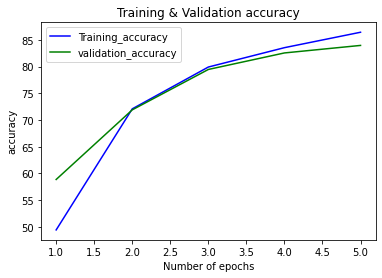

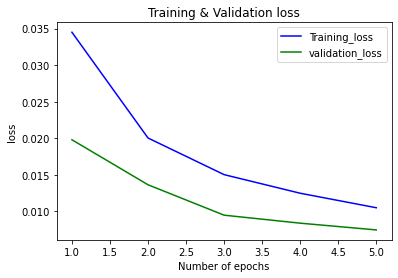

In [26]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')
plot_result(total_train_loss, total_valid_loss, 'loss')